In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl

from model import vdm_model, networks
from utils import compute_pk
from data import constants

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300

In [3]:
def load_model(dataset = 'Astrid',
        cropsize = 256,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = True,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,cropsize,cropsize),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    
    ckpt = 'ckpt_path'
    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [4]:
vdm = load_model()

In [5]:
# Load data
mass_mstar = np.load('Maps_Mstar_Astrid_CV_z=0.00.npy')
mass_cdm = np.load('Maps_Mcdm_Astrid_CV_z=0.00.npy')
mass_mstar = np.log10(mass_mstar+1)
mass_cdm = np.log10(mass_cdm)

mean_input = constants.norms['Astrid'][0]
std_input = constants.norms['Astrid'][1]
mean_target = constants.norms['Astrid'][2]
std_target = constants.norms['Astrid'][3]

mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)

In [6]:
box_size = 25.

In [7]:
def generate_samples(conditioning, batch_size=10, n=10):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2])

    maps = [] # 10 tensors of shape ([10, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        
    return maps

In [8]:
idx = 10

In [9]:
generated_fiducial_normed = torch.vstack(
    generate_samples(
        conditioning=mass_mstar_normed[idx].to(device), 
        batch_size=20, 
        n=5,
    )
)
generated_fiducial = generated_fiducial_normed * std_target + mean_target

In [10]:
k, fiducial_pk = compute_pk(10**mass_cdm[idx][None,None],)
k, stars_pk = compute_pk(10**mass_mstar[idx][None,None]-1)
k, cross_stars_true = compute_pk(10**mass_mstar[idx][None,None], 10**mass_cdm[idx][None,None])

In [11]:
generated_pk, cross_stars_pk, cross_true_pk = [], [], []
for sample in generated_fiducial:
    generated_pk.append(compute_pk(10**sample.cpu().numpy()[None])[1])
    k, cross_stars_sample = compute_pk(10**mass_mstar[idx][None][None]-1, 10**sample[None].cpu().numpy())
    cross_stars_pk.append(cross_stars_sample)
    k, cross_true_sample = compute_pk(10**mass_cdm[idx][None][None], 10**sample[None].cpu().numpy())
    cross_true_pk.append(cross_true_sample)
generated_pk = torch.stack(generated_pk)
cross_stars_pk = torch.stack(cross_stars_pk)
cross_true_pk = torch.stack(cross_true_pk)

In [31]:
post_mean = torch.mean(generated_fiducial, dim=0).squeeze().detach().cpu().numpy()
post_std = torch.std(generated_fiducial, dim=0).squeeze().detach().cpu().numpy()

In [36]:
from matplotlib.colors import TwoSlopeNorm

z_score = (mass_cdm[idx].squeeze() - post_mean) / post_std
diverging_norm = TwoSlopeNorm(vmin=z_score.min(), vcenter=0, vmax=z_score.max())

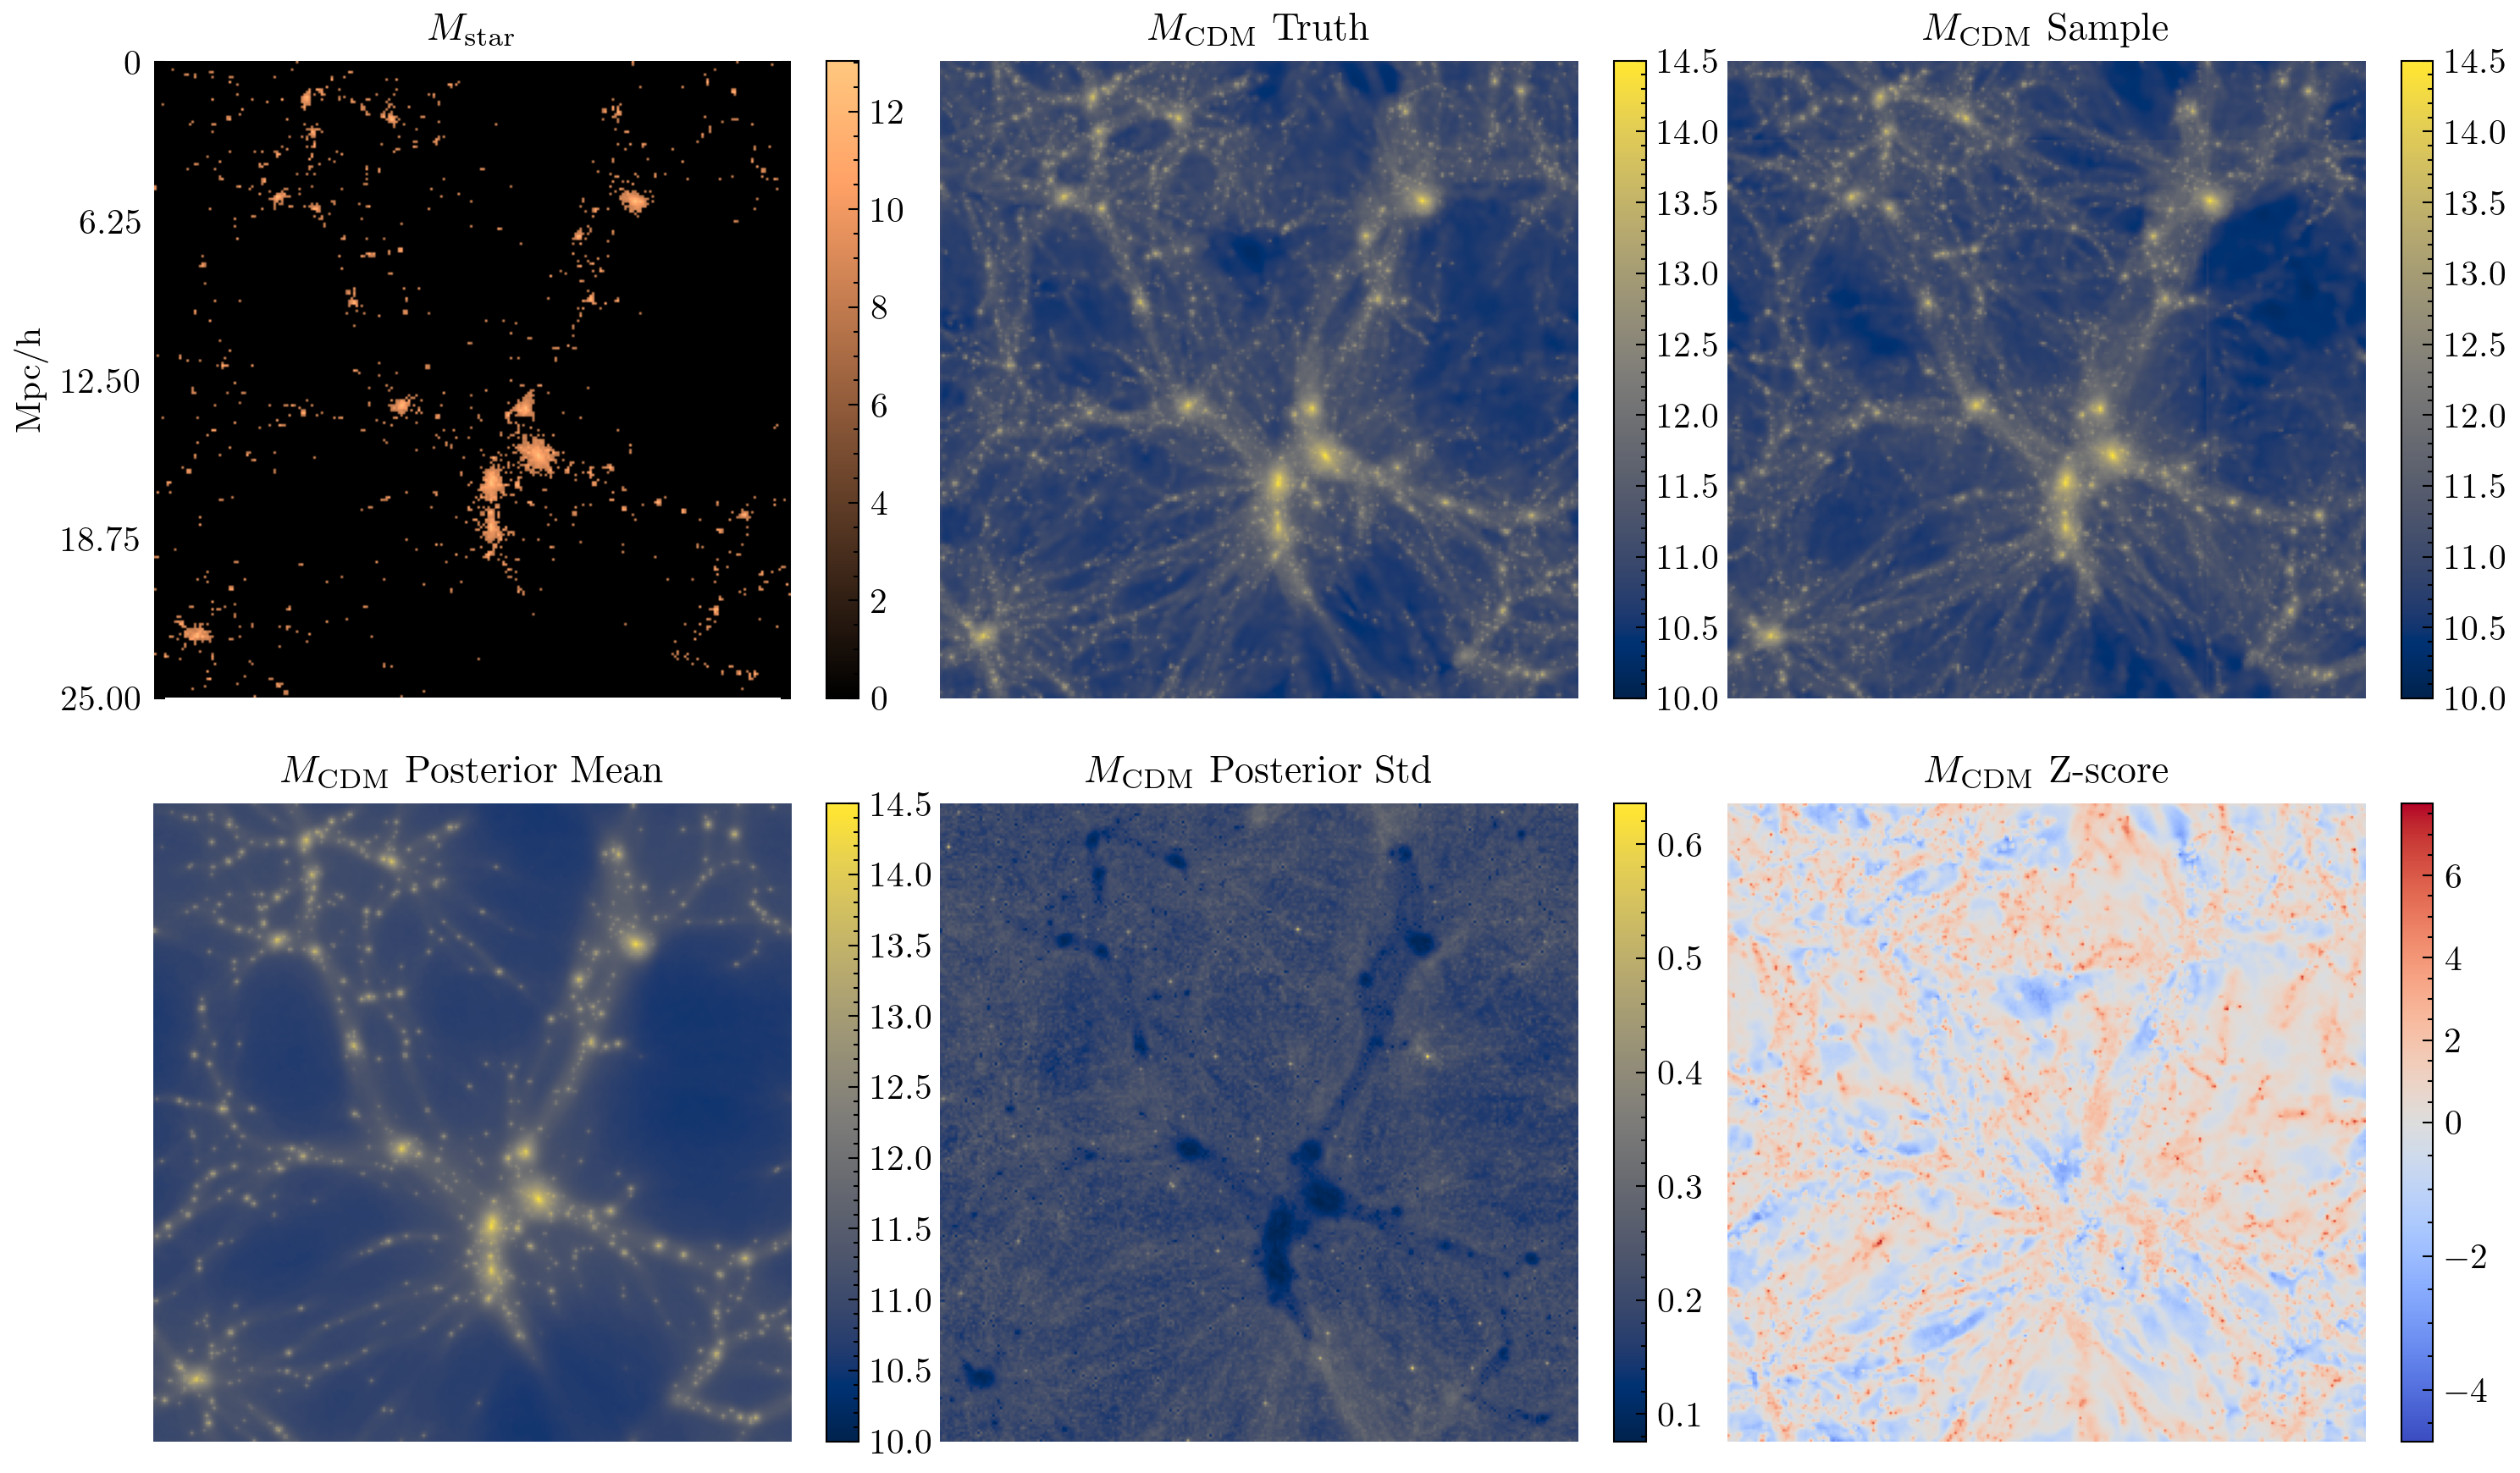

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(10,6))
fig.subplots_adjust(wspace=0.1)
axes = axes.flatten()
plt.rcParams.update({
    'axes.titlesize': 11,
    'legend.loc': 'upper right',
    'legend.fontsize': 6
    })
img = axes[0].imshow(mass_mstar[idx].squeeze(), cmap='copper')
fig.colorbar(img, ax=axes[0], fraction=0.045)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks([])
axes[0].set_yticks([0., 64., 128., 192., 256.], labels=["0", "6.25", "12.50", "18.75", "25.00"])
axes[0].set_ylabel("Mpc/h")        
img = axes[1].imshow(mass_cdm[idx].squeeze(), cmap='cividis',vmin=10,vmax=14.5)
fig.colorbar(img, ax=axes[1], fraction=0.045)
axes[1].axis('off')

img = axes[2].imshow(generated_fiducial[idx].squeeze().cpu(), cmap='cividis',vmin=10, vmax=14.5)
fig.colorbar(img, ax=axes[2], fraction=0.045)
axes[2].axis('off')


img = axes[3].imshow(post_mean, cmap='cividis', vmin=10,vmax=14.5)
cbar = fig.colorbar(img, ax=axes[3], fraction=0.045)
axes[3].axis('off')

img = axes[4].imshow(post_std, cmap='cividis', )#norm=LogNorm())
cbar = fig.colorbar(img, ax=axes[4], fraction=0.045)

axes[4].axis('off')
img = axes[5].imshow(z_score.squeeze(), cmap='coolwarm', norm=diverging_norm)
cbar = fig.colorbar(img, ax=axes[5], fraction=0.045)
axes[5].axis('off')
axes[0].set_title(r"$M_{\mathrm{star}}$")
axes[1].set_title(r"$M_{\mathrm{CDM}}$ Truth")
axes[2].set_title(r"$M_{\mathrm{CDM}}$ Sample")
axes[3].set_title(r"$M_{\mathrm{CDM}}$ Posterior Mean")
axes[4].set_title(r"$M_{\mathrm{CDM}}$ Posterior Std")
axes[5].set_title(r"$M_{\mathrm{CDM}}$ Z-score")

plt.tight_layout()


In [12]:
k_idx = np.unique(np.arange(len(k))[np.logspace(0,np.log10(len(k)),50).astype(int)])

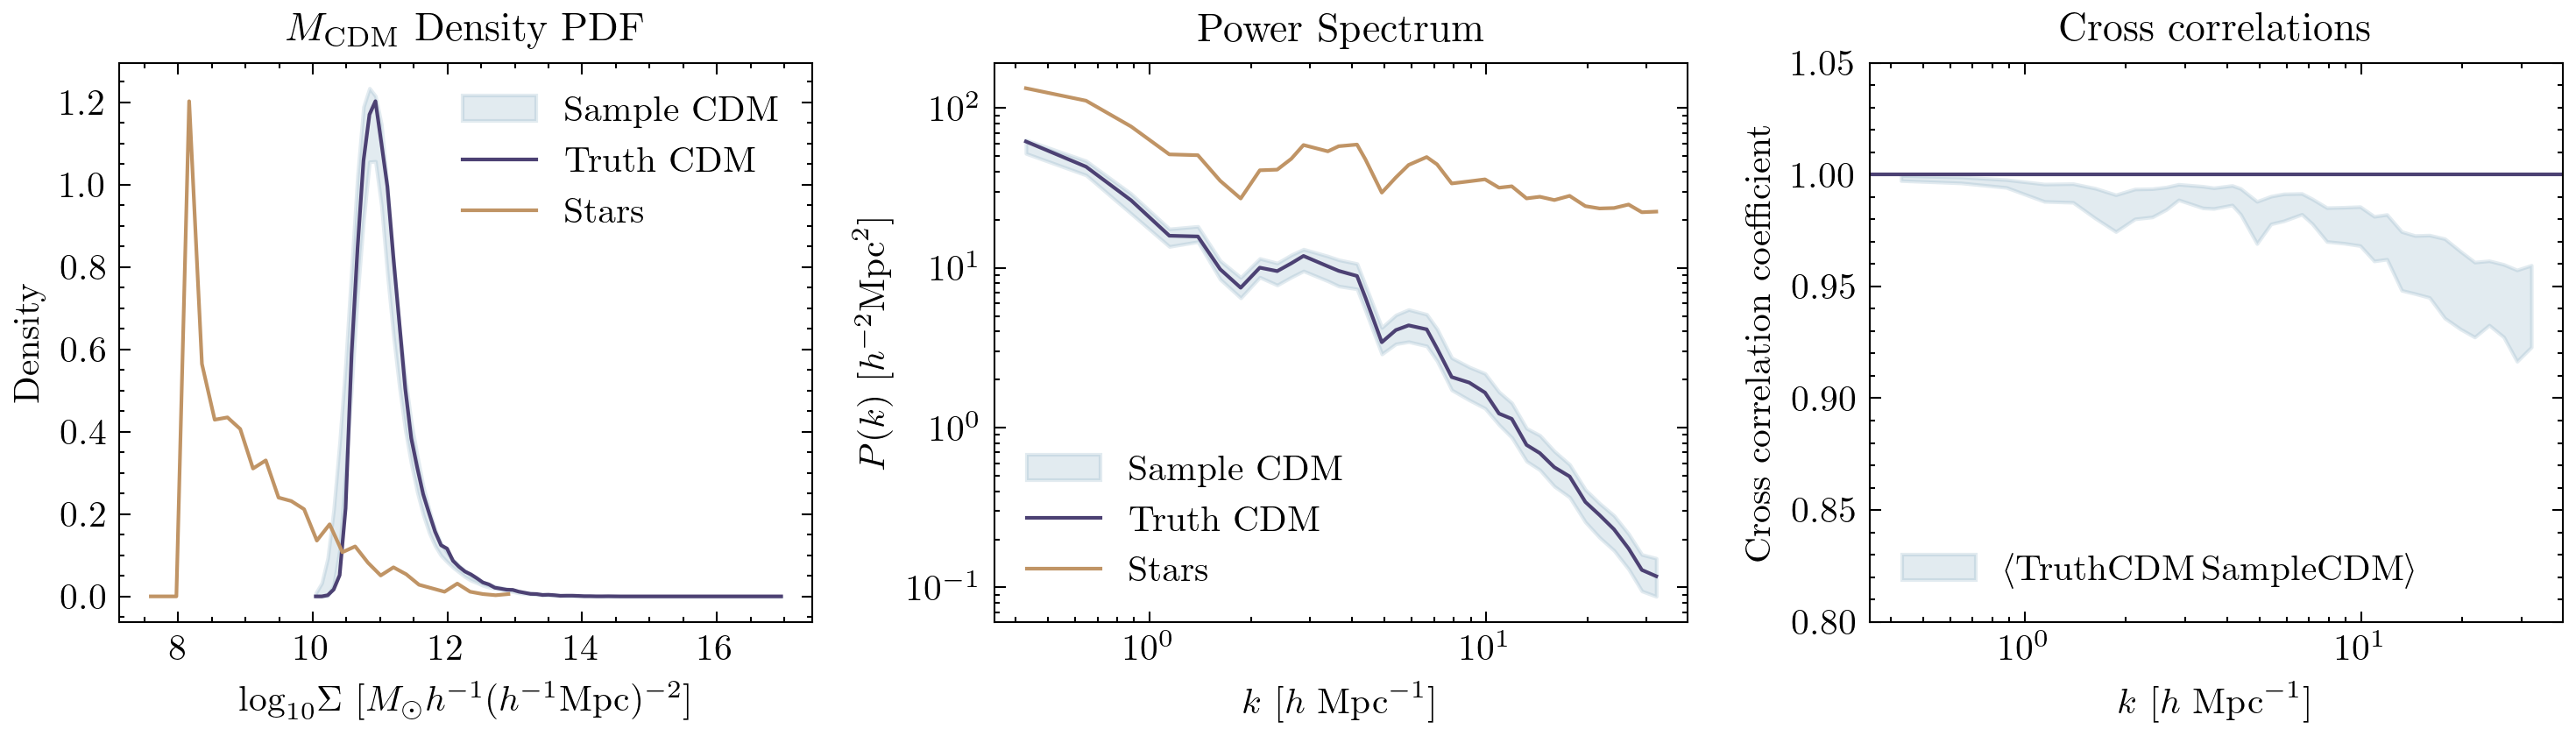

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(10,3))
fig.subplots_adjust(wspace=0.1)
axes = axes.flatten()
plt.rcParams.update({
    'axes.titlesize': 11,
    'legend.loc': 'upper right',
    'legend.fontsize': 6
    })


cdm_bins = np.linspace(10,17.,80)
cdm_bins_c = 0.5*(cdm_bins[1:] + cdm_bins[:-1])
star_bins = np.linspace(7.5,13,30)
star_bins_c = 0.5*(star_bins[1:] + star_bins[:-1])
hist_generated = []
for i in range(len(generated_fiducial)):
    gen_hist, _ = np.histogram(generated_fiducial[i].squeeze().cpu().numpy().flatten(), bins=cdm_bins, density=True,)
    hist_generated.append(gen_hist)
axes[0].fill_between(
    cdm_bins_c, 
    np.percentile(hist_generated, 10, axis=0), 
    np.percentile(hist_generated, 90, axis=0), 
    color='#709bb5', label='Sample CDM',
    alpha=0.2,
)
axes[0].plot(cdm_bins_c,np.histogram(mass_cdm[idx].squeeze().flatten(), bins=cdm_bins, density=True)[0],  color='#4c4173', label="Truth CDM", )
axes[0].plot(star_bins_c,np.histogram(mass_mstar[idx].squeeze().flatten(), bins=star_bins, density=True)[0],  color='#C09465', label="Stars", )
axes[0].set_title(r'$M_{\mathrm{CDM}}$ Density PDF') 
axes[0].set_xlabel(r'$\mathrm{log}_{10} \Sigma$ ' + '$[M_{\odot} h^{-1} ( h^{-1} \mathrm{Mpc})^{-2}]$')
axes[0].set_ylabel('Density')
axes[0].legend(fontsize=10)

axes[1].fill_between(
    k[k_idx],
    np.percentile(generated_pk[:, k_idx].cpu().numpy(), 10,axis=0),
    np.percentile(generated_pk[:, k_idx].cpu().numpy(), 90,axis=0),
    color='#709bb5', alpha=0.2, label='Sample CDM'
)
axes[1].loglog(k[k_idx], fiducial_pk[k_idx] , color='#4c4173', label="Truth CDM", )
axes[1].loglog(k[k_idx], stars_pk[k_idx], color='#C09465', label="Stars", )
axes[1].set_ylabel('$P(k)$ [$h^{-2}\mathrm{Mpc}^2$]')
axes[1].set_xlabel('$k$ [$h \ \mathrm{Mpc}^{-1}$]')
axes[1].set_title('Power Spectrum')
axes[1].legend(fontsize=10, loc='lower left')

axes[2].fill_between(
    k[k_idx],
    np.percentile(cross_true_pk[:, k_idx].cpu().numpy() / np.sqrt(fiducial_pk[k_idx]) / np.sqrt(generated_pk[:, k_idx].cpu()),10, axis=0),
    np.percentile(cross_true_pk[:, k_idx].cpu().numpy() / np.sqrt(fiducial_pk[k_idx]) / np.sqrt(generated_pk[:, k_idx].cpu()),90, axis=0),
    color='#709bb5',
    alpha=0.2,
    label=r'$\langle \text{TruthCDM} \, \text{SampleCDM} \rangle$' ,
)
axes[2].set_xscale('log')
axes[2].axhline(1, color='#4c4173')
axes[2].set_ylim(0.8,1.05)
axes[2].set_ylabel('Cross correlation coefficient')
axes[2].set_xlabel('$k$ [$h \ \mathrm{Mpc}^{-1}$]')
axes[2].set_title('Cross correlations')
axes[2].legend(fontsize=10, loc='lower left')

plt.tight_layout()